In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import normalize
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import scipy
from audio_utils import downsampleLabels, extractMelSpecs, windowEEG, stackFeatures

In [2]:
path = Path('sentences_data/sentences/')
outPath = Path('./eeg/')
patient_data = {}
i=0

for file in path.rglob('*sentences.xdf'):
    if i == 1:
         break
    
    
    patient_id, session_id = file.name.split("_")[:2]
    print(f"Patient ID: {patient_id}, session: {session_id}")
    eeg_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_sEEG.npy")
    audio_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_audio.npy")
    ch_names = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_channelNames.npy")
    sentences_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences.npy")

    patient_data[(patient_id, session_id)] = {
         "eeg":eeg_ts,
         "audio":audio_ts,
         "channels":ch_names,
         "sentences":sentences_ts,
         "labels":[1 if x != 0 else x for x in np.unique(sentences_ts, return_inverse=True)[1]] # speech/no speech
    }

    i+=1

Patient ID: p00, session: ses1


In [20]:
winL = 0.05
frameshift = 0.01
modelOrder = 4
stepSize = 5

audio_sr = 48000
eeg_sr = 1024

#Extract HG features
eeg = windowEEG(eeg_ts,eeg_sr, windowLength=winL,frameshift=frameshift)

#Stack features
# eeg = stackFeatures(eeg,modelOrder=modelOrder,stepSize=stepSize)

#Process Audio
target_SR = 16000
audio = scipy.signal.decimate(audio_ts, int(audio_sr / target_SR))
audio_sr = target_SR
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767) # stanmdard waveformat 

#Extract spectrogram
melSpec = extractMelSpecs(scaled,audio_sr,windowLength=winL,frameshift=frameshift)

#Align to EEG features
sentences = downsampleLabels(sentences_ts, eeg_sr, windowLength=winL, frameshift=frameshift)
sentences = sentences[modelOrder*stepSize:sentences.shape[0]-modelOrder*stepSize]
melSpec = melSpec[modelOrder*stepSize:melSpec.shape[0]-modelOrder*stepSize,:]

#adjust length (differences might occur due to rounding in the number of windows)
if melSpec.shape[0]!=eeg.shape[0]:
    tLen = np.min([melSpec.shape[0],eeg.shape[0]])
    melSpec = melSpec[:tLen,:]
    eeg = eeg[:tLen,:]

In [21]:
print(eeg.shape)
print(sentences.shape)
print(melSpec.shape)

(50001, 110)
(50001,)
(50001, 23)


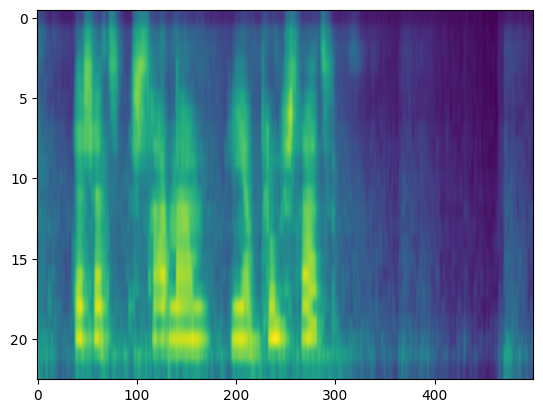

In [20]:
cm='viridis'
fig, ax = plt.subplots(1, sharex=True)

#Which timeframe to plot
start_s = 5.5
stop_s=10.5

#Plot spectrograms
pSta=int(start_s*(1/frameshift));
pSto=int(stop_s*(1/frameshift))
ax.imshow(np.flipud(melSpec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import zscore

# Setting random seed for reproducibility
torch.manual_seed(42)

class EegDataset(Dataset):

    def __init__(self, data, seq_len=1):
        
        self.eeg_tensor = torch.Tensor(zscore(data))
        self.seq_len = seq_len
        
    def __getitem__(self, index):
        start_idx = index
        end_idx = index + self.seq_len


        # Check if the sequence goes beyond the data length
        if end_idx > len(self):
            # If so, pad the sequence
            padded_sequence = torch.zeros(self.seq_len, self.eeg_tensor.shape[1])
            padded_sequence[:len(self) - index, :] = self.eeg_tensor[index:, :]
            return padded_sequence
        else:
            return self.eeg_tensor[start_idx:end_idx, :]
        
    
    def __len__(self):
        return self.eeg_tensor.shape[0]
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, seq_length):
        super(Autoencoder, self).__init__()
        
        print(f"\nNumber of channels: {input_size}")
        print(f"Length of sequence: {seq_length}")
        encoder_input_size = (2*input_size)-1
        self.input_size = input_size
        self.seq_length = seq_length

        self.input_layer = nn.Sequential(
            nn.Conv1d(in_channels=seq_length, out_channels=100, kernel_size=input_size, padding="valid", stride=1),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=75, kernel_size=5, stride=2),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Conv1d(in_channels=75, out_channels=50, kernel_size=5, stride=2),
            nn.BatchNorm1d(50),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=50, out_channels=75, kernel_size=5, stride=2),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=75, out_channels=100, kernel_size=5, stride=2),
            nn.BatchNorm1d(100),
            nn.ReLU()
            )

        self.output_layer = nn.Sequential(
            nn.ConvTranspose1d(in_channels=100, out_channels=seq_length, kernel_size=int(input_size), stride=1),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
        ) 
        
    def forward(self, x):

        X_ext = torch.concat((x[:,:,:], x[:,:,:-1]), 2)
        print(X_ext.shape)
        
        X_in = self.input_layer(X_ext)
        print(f"X shape after input layer: ", X_in.shape)

        X_enc = self.encoder(X_in)
        print(f"X shape after encoder: ", X_enc.shape)

        X_dec = self.decoder(X_enc)
        print(f"X shape after decoder: ", X_dec.shape)

        X_out = self.output_layer(X_dec)
        print(f"X shape after output layer: ", X_out.shape)
        # X_output = X_out[:,:,:self.input_size]
        X_out_padded = torch.nn.functional.pad(X_out,(0,2,0,0,0,0), "constant",0)

        X_output = (X_out[:,:,:self.input_size] + X_out_padded[:,:,self.input_size:]) / 2

        return X_output

class Shallow_Autoencoder(nn.Module):
  def __init__(self, input_size, seq_length):
    super(Shallow_Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=100),
            nn.BatchNorm1d(seq_length),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=25),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
        )

    self.decoder = nn.Sequential(
            nn.Linear(in_features=25, out_features=100),
            nn.BatchNorm1d(seq_length),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=input_size),
            nn.BatchNorm1d(seq_length),
            nn.ReLU()
    )

  def forward(self, x):
    x_enc = self.encoder(x)
    x_dec = self.decoder(x_enc)

    return x_dec
  
class Basic_CNN(nn.Module):
  def __init__(self, input_size, filter_length=1):
    super(Basic_CNN, self).__init__()
    print(f"\nFilter length: {filter_length}")
    print(f"Number of filters: {input_size}")
    self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=75, kernel_size=5, stride=1, padding="valid"),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Conv1d(in_channels=75, out_channels=25, kernel_size=5, stride=1, padding="valid"),
            nn.BatchNorm1d(25),
            nn.ReLU(),
        )

    self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=25, out_channels=75, kernel_size=5, stride=1),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=75, out_channels=input_size, kernel_size=5, stride=1),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
            )

  def forward(self, x):
    x_enc = self.encoder(x)
    x_dec = self.decoder(x_enc)
    # print(x_enc.shape)
    # print(x_dec.shape)

    return x_dec

In [106]:
n_batches = 4056

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

eeg_sr = 1024
window_dr = 0.05 # 50ms
window_length = int(eeg_sr * window_dr)
# seq_len = window_length * 2

dataset = EegDataset(eeg_ts, seq_len=window_length)
dataloader = DataLoader(dataset=dataset, batch_size=n_batches, shuffle=False)

# Model Initialization
model = Basic_CNN(input_size=dataset.eeg_tensor.shape[1], filter_length=window_length)
model = model.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3)


cuda:0

Filter length: 51
Number of filters: 110


In [107]:
n_epochs = 10
epoch_loss = []
for epoch in range(n_epochs):
    running_loss_arr = []
    running_loss = 0

    training_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for batch_idx, X in training_loop:
        # if batch_idx == 1:
        #     break
        X = X.permute(0, 2, 1)
        X = X.to(device)

        X_rec = model(X)
        # print(X_rec.shape)
        loss = loss_function(X_rec, X)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss_arr.append(loss.item())
        running_loss += loss.item() * X.shape[0]
        
        # update progress bar
        training_loop.set_description(f"Epoch {epoch+1}/{n_epochs}")
        # training_loop.set_postfix(loss=running_loss)
    epoch_loss.append(running_loss / n_batches)

<Axes: >

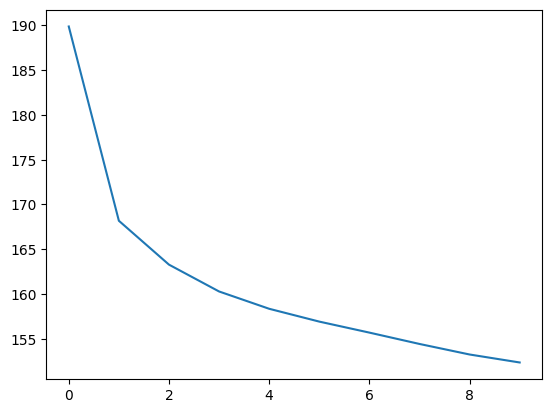

In [105]:
import seaborn as sns

sns.lineplot(epoch_loss)

(512475, 110)

In [17]:
eeg = patient_data[(patient_id, session_id)]["eeg"]

# Generate indices for snippets
num_snippets = eeg.shape[0] // seq_len
snippet_indices = np.arange(0, num_snippets * seq_len, seq_len)

# Extract snippets from the data
X_train = np.zeros((num_snippets, seq_len, eeg.shape[1]))

for i, idx in enumerate(snippet_indices):
    X_train[i] = eeg[idx:idx+seq_len, :]

In [21]:
X_train[0].shape

(51, 110)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test, y_test)

In [74]:
# class Basic_CNN(nn.Module):
#   def __init__(self, input_size, seq_length):
#     super(Basic_CNN, self).__init__()

#     self.encoder = nn.Sequential(
#             nn.Conv1d(in_channels=seq_length, out_channels=100, kernel_size=5, stride=2),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=100, out_channels=50, kernel_size=5, stride=2),
#             nn.BatchNorm1d(50),
#             nn.ReLU()
#         )

#   def forward(self, x):
#     x_enc = self.encoder(x)
#     x_dec = self.decoder(x_enc)

#     return x_dec
n = 110
l = 52
input_a = torch.rand(1,n,l)
print(input_a.shape)

conv_lay_1 = nn.Conv1d(in_channels=n,out_channels=75,kernel_size=5,stride=2, padding="valid")
output_1 = conv_lay_1(input_a)
print(output_1.shape)

# avg_lay_1 = nn.AvgPool1d(kernel_size=1024)
# output_2 = avg_lay_1(output_1)
# print(output_2.shape)

conv_lay_2 = nn.Conv1d(in_channels=75, out_channels=50,kernel_size=5,stride=2, padding="valid")
output_2 = conv_lay_2(output_1)

print(output_2.shape)


deconv_lay_1 = nn.ConvTranspose1d(in_channels=50, out_channels=75,kernel_size=5,stride=2)
pad_lay_1 = nn.ZeroPad1d((0,1))
output_3 = deconv_lay_1(output_2)
output_3 = pad_lay_1(output_3)
print(output_3.shape)

deconv_lay_2 = nn.ConvTranspose1d(in_channels=75, out_channels=n,kernel_size=5, stride=2)
output_4 = deconv_lay_2(output_3)
output_4 = pad_lay_1(output_4)
print(output_4.shape)

torch.Size([1, 110, 52])
torch.Size([1, 75, 24])
torch.Size([1, 50, 10])
torch.Size([1, 75, 24])
torch.Size([1, 110, 52])


In [64]:
output_1[:,:,:10].shape

torch.Size([1, 2, 9])